In [1]:
# Import the modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as tf
import matplotlib.pyplot as plt
from PIL import Image
import scipy.io as sio
from google.colab import drive
import numpy as np
import tensorflow.keras.layers as kl
import os, random, math
from pprint import pprint
from datetime import datetime as dt

import keras as k

# Mount Google Drive
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/DeepLearning_2020/FinalProject/New_Dataset'
results_path = '/content/drive/My Drive/DeepLearning_2020/FinalProject/New_Dataset/Results'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Using TensorFlow backend.


In [0]:
# Data configuration
#Path to image folders
training_set_folder = data_path + '/Training_small' 
test_set_folder     = data_path + '/Test_small'

# Model configuration
batch_size = 32
#Image size width x height, RGB= 3 channels
img_width, img_height, img_num_channels = 50, 50, 3
loss_function = sparse_categorical_crossentropy
no_classes = 13 
no_epochs = 20
optimizer = Adam()
verbosity = 1     #to display output on scren

In [3]:
#TEST
# Determine shape of the data
input_shape = (img_width, img_height, img_num_channels)

'''Our training data will use transformations to try as much variety as possible out of our images.
 However, for the validation data, we'll apply just one transformation,
 rescaling, because we want our validation set to reflect "real world"
 performance.'''
# So we create a generator. 
# Validation data shouldn't be augmented, but it should also be scaled, so we rescale the pixel values from [0, 255] to [0, 1] interval
test_datagen = ImageDataGenerator(rescale=1./255)

#create images iterators 
"""
flow_from_directory() automatically infers the labels from the directory structure of the folders containing images. 
Every subfolder inside the training-folder(or validation-folder) will be considered a target class.
"""
test_datagen = test_datagen.flow_from_directory(
        test_set_folder,
        batch_size = batch_size,
        target_size = (50, 50),
        class_mode = 'sparse')

Found 676 images belonging to 13 classes.


In [4]:
# TRAIN
# Determine shape of the data
input_shape = (img_width, img_height, img_num_channels)
#In the case of the training set we apply several transformations, and of course also the reescaling.
train_datagen = ImageDataGenerator(rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_datagen = train_datagen.flow_from_directory(
        training_set_folder,
        batch_size = batch_size,
        target_size = (50, 50),
        class_mode = 'sparse')

Found 2176 images belonging to 13 classes.


In [0]:
#In order to generate a subplot with a sample of images
def get_subplot_grid(mylist, columns, figwidth, figheight):
    plot_rows = math.ceil(len(mylist) / 2.)
    fig, ax = plt.subplots(plot_rows, 2, sharey=True, sharex=False)
    fig.set_figwidth(figwidth)
    fig.set_figheight(figheight)
    fig.subplots_adjust(hspace=0.4)
    axflat = ax.flat
    for ax in axflat[ax.size - 1:len(mylist) - 1:-1]:
        ax.set_visible(False)

    return fig, axflat

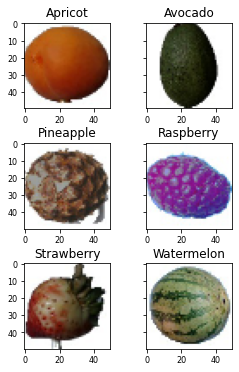

<Figure size 432x288 with 0 Axes>

In [6]:
#Plot some fruits with the corresponding labels
test_images_classes = ["Apricot","Avocado","Pineapple","Raspberry","Strawberry","Watermelon"]

test_images=[]

plt.rc('font',family = 'sans-serif',  size=8)
fig, axflat = get_subplot_grid(mylist=test_images_classes, columns=2, figwidth=4, figheight=6)

for idx, label in enumerate(test_images_classes):
    image_folder = os.path.join(training_set_folder, label)
    image_file = os.path.join(image_folder, random.choice(os.listdir(image_folder)) )
    loaded_image = k.preprocessing.image.load_img(path=image_file,target_size=(img_width, img_height, img_num_channels))
    #convert to array and resample dividing by 255
    img_array = k.preprocessing.image.img_to_array(loaded_image) / 255.
    test_images.append({"idx":idx, "image":img_array, "label": label})
    
    axflat[idx].set_title(label, size=12)
    axflat[idx].imshow(img_array)
plt.show()
plt.gcf().clear()

In [7]:
'''We will see how many fruits of each type the training dataset contains'''
#train_images_iter.class_indices contain the label-index map for each inferred class
trained_classes_labels = list(train_datagen.class_indices.keys())
print(train_datagen.class_indices)
#train_images_iter.classes contains a list of classes of each image
unique, counts = np.unique(train_datagen.classes, return_counts=True)
print ("number of samples per class")
dict(zip(train_datagen.class_indices, counts))

{'Apricot': 0, 'Avocado': 1, 'Banana': 2, 'Cauliflower': 3, 'Cocos': 4, 'Corn': 5, 'Lemon': 6, 'Mandarine': 7, 'Pear': 8, 'Pineapple': 9, 'Raspberry': 10, 'Strawberry': 11, 'Watermelon': 12}
number of samples per class


{'Apricot': 170,
 'Avocado': 163,
 'Banana': 171,
 'Cauliflower': 156,
 'Cocos': 171,
 'Corn': 171,
 'Lemon': 165,
 'Mandarine': 165,
 'Pear': 180,
 'Pineapple': 173,
 'Raspberry': 159,
 'Strawberry': 172,
 'Watermelon': 160}

In [8]:
'''We will see how many fruits of each type the test dataset contains'''

#test_images_iter.class_indices contain the label-index map for each inferred class
test_classes_labels = list(test_datagen.class_indices.keys())
print(test_datagen.class_indices)
#test_images_iter.classes contains a list of classes of each image
unique, counts = np.unique(test_datagen.classes, return_counts=True)
print ("number of samples per class")
dict(zip(test_datagen.class_indices, counts))

{'Apricot': 0, 'Avocado': 1, 'Banana': 2, 'Cauliflower': 3, 'Cocos': 4, 'Corn': 5, 'Lemon': 6, 'Mandarine': 7, 'Pear': 8, 'Pineapple': 9, 'Raspberry': 10, 'Strawberry': 11, 'Watermelon': 12}
number of samples per class


{'Apricot': 52,
 'Avocado': 52,
 'Banana': 52,
 'Cauliflower': 52,
 'Cocos': 52,
 'Corn': 52,
 'Lemon': 52,
 'Mandarine': 52,
 'Pear': 52,
 'Pineapple': 52,
 'Raspberry': 52,
 'Strawberry': 52,
 'Watermelon': 52}

In [9]:
# Create the model 1
model1 = Sequential()
model1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.2))

model1.add(Flatten())

model1.add(Dense(20, activation='relu'))
model1.add(Dense(no_classes, activation='softmax'))

model1.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 20)                368660    
_________________________________________________________________
dense_1 (Dense)              (None, 13)                273       
Total params: 369,829
Trainable params: 369,829
Non-trainable params: 0
__________________________________________________

In [10]:
model1.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['accuracy'])

# Start testing
history = model1.fit(
        train_datagen,
        epochs = no_epochs,
        validation_data = test_datagen,

        shuffle = False)



Epoch 1/20
68/68 [==============================] - 10s 149ms/step - loss: 2.4757 - accuracy: 0.1016 - val_loss: 2.3302 - val_accuracy: 0.1331
Epoch 2/20
68/68 [==============================] - 10s 149ms/step - loss: 2.1098 - accuracy: 0.2486 - val_loss: 1.8923 - val_accuracy: 0.3891
Epoch 3/20
68/68 [==============================] - 10s 147ms/step - loss: 1.7168 - accuracy: 0.4251 - val_loss: 1.6542 - val_accuracy: 0.4275
Epoch 4/20
68/68 [==============================] - 10s 147ms/step - loss: 1.4727 - accuracy: 0.5028 - val_loss: 1.3829 - val_accuracy: 0.4867
Epoch 5/20
68/68 [==============================] - 10s 148ms/step - loss: 1.3193 - accuracy: 0.5312 - val_loss: 1.2283 - val_accuracy: 0.5636
Epoch 6/20
68/68 [==============================] - 10s 147ms/step - loss: 1.1677 - accuracy: 0.6103 - val_loss: 1.1455 - val_accuracy: 0.6553
Epoch 7/20
68/68 [==============================] - 10s 146ms/step - loss: 0.9938 - accuracy: 0.7114 - val_loss: 0.8981 - val_accuracy: 0.6760

In [11]:
score = model1.evaluate(test_datagen)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


22/22 [==============================] - 1s 64ms/step - loss: 0.2860 - accuracy: 0.9364
Test loss: 0.28603050112724304
Test accuracy: 0.9363905191421509


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


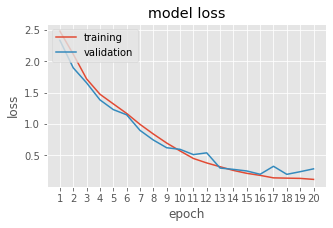

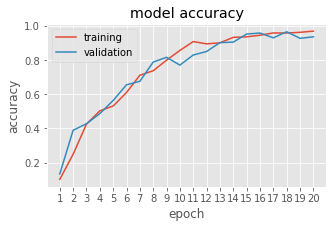

In [12]:
print(history.history.keys())

plt.style.use('ggplot')

xepochs = [i+1 for i in range(0, len(history.history['loss']))]
plt.figure(figsize=(5,3))
# Loss
#plt.ylim([-0.1,0.5])
plt.plot(xepochs, history.history['loss'])
plt.plot(xepochs, history.history['val_loss'])
plt.xticks(xepochs)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

# Accuracy
#plt.ylim([0.7,1.05])
plt.figure(figsize=(5,3))
plt.plot(xepochs, history.history['accuracy'])
plt.plot(xepochs, history.history['val_accuracy'])
plt.xticks(xepochs)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [13]:
#probar new model

newmodel=Sequential()
newmodel.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
newmodel.add(MaxPooling2D(pool_size=(2, 2)))
newmodel.add(kl.BatchNormalization())

newmodel.add(Dropout(0.2))

newmodel.add(Flatten())

newmodel.add(Dense(20, activation='relu'))
newmodel.add(Dense(no_classes, activation='softmax'))
newmodel.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 24, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                368660    
_________________________________________________________________
dense_3 (Dense)              (None, 13)               

In [14]:

newmodel.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['accuracy'])

from datetime import datetime as dt
start = dt.now()
history = newmodel.fit(
  # training data
  train_datagen,

  epochs = no_epochs, 

  # validation data
  validation_data = test_datagen,
  
)


Epoch 1/20
68/68 [==============================] - 10s 152ms/step - loss: 1.6563 - accuracy: 0.4499 - val_loss: 5.3522 - val_accuracy: 0.1583
Epoch 2/20
68/68 [==============================] - 10s 152ms/step - loss: 0.9230 - accuracy: 0.6723 - val_loss: 1.6149 - val_accuracy: 0.5251
Epoch 3/20
68/68 [==============================] - 10s 149ms/step - loss: 0.5304 - accuracy: 0.8042 - val_loss: 1.8447 - val_accuracy: 0.3876
Epoch 4/20
68/68 [==============================] - 10s 149ms/step - loss: 0.3608 - accuracy: 0.8787 - val_loss: 2.4494 - val_accuracy: 0.4512
Epoch 5/20
68/68 [==============================] - 10s 149ms/step - loss: 0.2732 - accuracy: 0.8966 - val_loss: 1.9858 - val_accuracy: 0.4837
Epoch 6/20
68/68 [==============================] - 10s 149ms/step - loss: 0.2558 - accuracy: 0.9090 - val_loss: 2.2703 - val_accuracy: 0.6183
Epoch 7/20
68/68 [==============================] - 10s 151ms/step - loss: 0.2055 - accuracy: 0.9343 - val_loss: 0.7834 - val_accuracy: 0.8817

In [15]:
score = newmodel.evaluate(test_datagen)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

22/22 [==============================] - 1s 62ms/step - loss: 0.8189 - accuracy: 0.8743
Test loss: 0.8189258575439453
Test accuracy: 0.8742603659629822


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


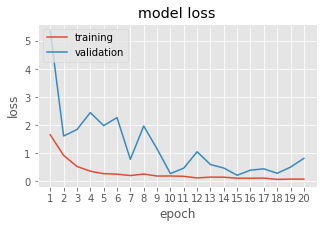

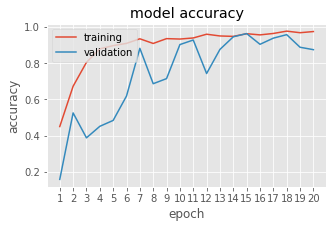

In [16]:
print(history.history.keys())

plt.style.use('ggplot')

xepochs = [i+1 for i in range(0, len(history.history['loss']))]
plt.figure(figsize=(5,3))
# Loss
#plt.ylim([-0.1,0.5])
plt.plot(xepochs, history.history['loss'])
plt.plot(xepochs, history.history['val_loss'])
plt.xticks(xepochs)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

# Accuracy
#plt.ylim([0.7,1.05])
plt.figure(figsize=(5,3))
plt.plot(xepochs, history.history['accuracy'])
plt.plot(xepochs, history.history['val_accuracy'])
plt.xticks(xepochs)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [17]:
# MODEL 3
model3 = Sequential()
model3.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model3.add(MaxPooling2D((2, 2)))
model3.add(Dropout(0.25))

model3.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model3.add(Dropout(0.4))

model3.add(Flatten())

model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.3))
model3.add(Dense(no_classes, activation='softmax'))
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 9, 9, 128)        

In [18]:

model3.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['accuracy'])

# testing
history = model3.fit(
        train_datagen,
        epochs = no_epochs,
          validation_data = test_datagen,

        shuffle = False)

Epoch 1/20
68/68 [==============================] - 16s 230ms/step - loss: 1.8037 - accuracy: 0.3318 - val_loss: 1.4454 - val_accuracy: 0.4379
Epoch 2/20
68/68 [==============================] - 16s 228ms/step - loss: 0.7850 - accuracy: 0.7137 - val_loss: 0.4091 - val_accuracy: 0.9098
Epoch 3/20
68/68 [==============================] - 16s 233ms/step - loss: 0.4170 - accuracy: 0.8295 - val_loss: 0.3972 - val_accuracy: 0.8876
Epoch 4/20
68/68 [==============================] - 16s 233ms/step - loss: 0.3291 - accuracy: 0.8764 - val_loss: 0.4259 - val_accuracy: 0.9275
Epoch 5/20
68/68 [==============================] - 16s 229ms/step - loss: 0.2285 - accuracy: 0.9145 - val_loss: 0.3462 - val_accuracy: 0.9497
Epoch 6/20
68/68 [==============================] - 16s 231ms/step - loss: 0.1809 - accuracy: 0.9352 - val_loss: 0.3731 - val_accuracy: 0.9467
Epoch 7/20
68/68 [==============================] - 16s 229ms/step - loss: 0.2060 - accuracy: 0.9251 - val_loss: 0.2322 - val_accuracy: 0.9453

22/22 [==============================] - 2s 74ms/step - loss: 0.4173 - accuracy: 0.9497
Test loss: 0.41727858781814575
Test accuracy: 0.9497041702270508
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


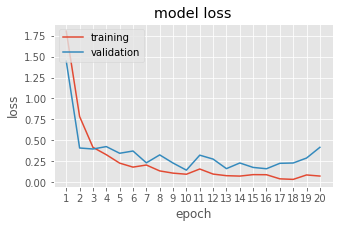

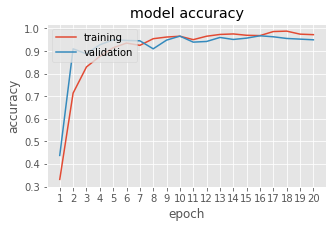

In [19]:
score = model3.evaluate(test_datagen)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print(history.history.keys())

plt.style.use('ggplot')

xepochs = [i+1 for i in range(0, len(history.history['loss']))]
plt.figure(figsize=(5,3))
# Loss
#plt.ylim([-0.1,0.5])
plt.plot(xepochs, history.history['loss'])
plt.plot(xepochs, history.history['val_loss'])
plt.xticks(xepochs)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

# Accuracy
#plt.ylim([0.7,1.05])
plt.figure(figsize=(5,3))
plt.plot(xepochs, history.history['accuracy'])
plt.plot(xepochs, history.history['val_accuracy'])
plt.xticks(xepochs)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.98%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '84.55%',
 'Lemon': '14.36%',
 'Mandarine': '0.01%',
 'Pear': '0.10%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Corn (class 5) 84.55%


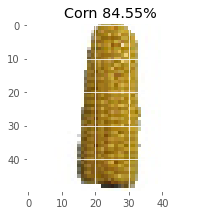

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.89%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '85.65%',
 'Lemon': '13.36%',
 'Mandarine': '0.01%',
 'Pear': '0.09%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Corn (class 5) 85.65%


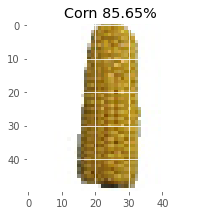

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '100.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Raspberry (class 10) 100.00%


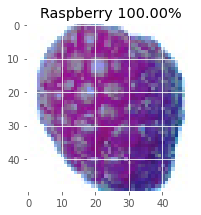

{'Apricot': '0.00%',
 'Avocado': '5.29%',
 'Banana': '0.00%',
 'Cauliflower': '87.05%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.28%',
 'Pineapple': '5.89%',
 'Raspberry': '0.00%',
 'Strawberry': '0.26%',
 'Watermelon': '1.22%'}
Prediction: Cauliflower (class 3) 87.05%


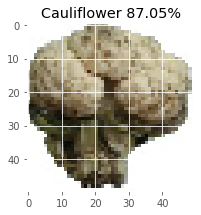

{'Apricot': '0.00%',
 'Avocado': '3.36%',
 'Banana': '0.00%',
 'Cauliflower': '89.88%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.27%',
 'Pineapple': '5.31%',
 'Raspberry': '0.00%',
 'Strawberry': '0.19%',
 'Watermelon': '0.98%'}
Prediction: Cauliflower (class 3) 89.88%


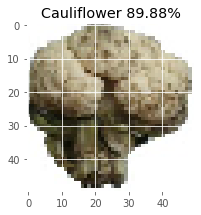

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '100.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Raspberry (class 10) 100.00%


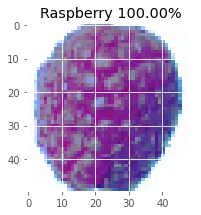

{'Apricot': '0.00%',
 'Avocado': '1.11%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.08%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '4.73%',
 'Watermelon': '94.07%'}
Prediction: Watermelon (class 12) 94.07%


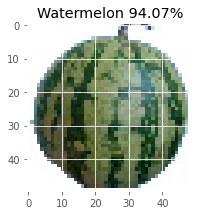

{'Apricot': '0.00%',
 'Avocado': '0.79%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.09%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '4.16%',
 'Watermelon': '94.96%'}
Prediction: Watermelon (class 12) 94.96%


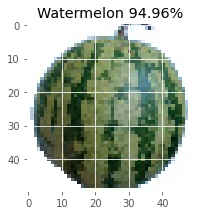

{'Apricot': '0.01%',
 'Avocado': '0.02%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.01%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.01%',
 'Pear': '0.00%',
 'Pineapple': '94.74%',
 'Raspberry': '0.00%',
 'Strawberry': '5.21%',
 'Watermelon': '0.00%'}
Prediction: Pineapple (class 9) 94.74%


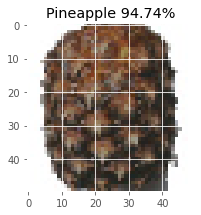

{'Apricot': '0.01%',
 'Avocado': '0.02%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.01%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.01%',
 'Pear': '0.00%',
 'Pineapple': '93.67%',
 'Raspberry': '0.00%',
 'Strawberry': '6.28%',
 'Watermelon': '0.00%'}
Prediction: Pineapple (class 9) 93.67%


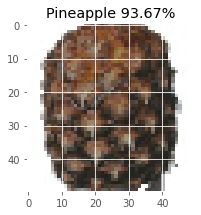

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.03%',
 'Mandarine': '99.97%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Mandarine (class 7) 99.97%


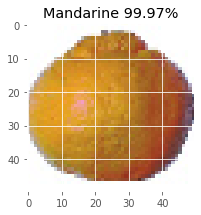

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.04%',
 'Mandarine': '99.95%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Mandarine (class 7) 99.95%


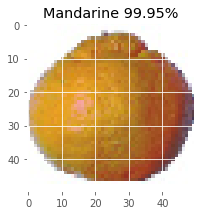

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '100.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Raspberry (class 10) 100.00%


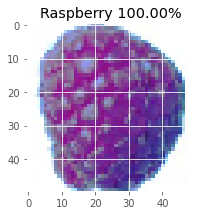

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '100.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Raspberry (class 10) 100.00%


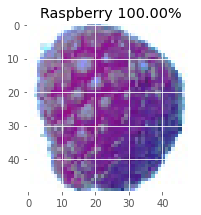

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '94.21%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '5.78%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Cocos (class 4) 94.21%


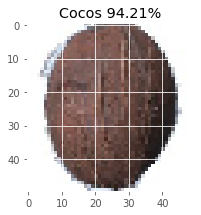

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '95.66%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '4.34%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Cocos (class 4) 95.66%


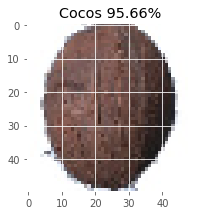

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.01%',
 'Mandarine': '99.99%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Mandarine (class 7) 99.99%


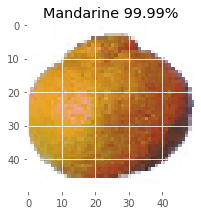

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.01%',
 'Mandarine': '99.99%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Mandarine (class 7) 99.99%


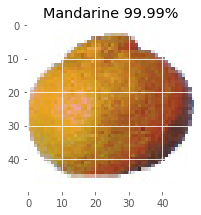

{'Apricot': '0.00%',
 'Avocado': '0.82%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.08%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '4.21%',
 'Watermelon': '94.89%'}
Prediction: Watermelon (class 12) 94.89%


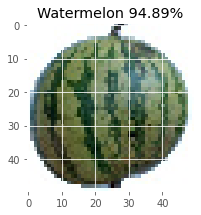

{'Apricot': '0.00%',
 'Avocado': '1.20%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.09%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '4.91%',
 'Watermelon': '93.80%'}
Prediction: Watermelon (class 12) 93.80%


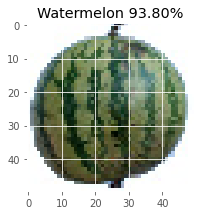

{'Apricot': '0.00%',
 'Avocado': '1.92%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '69.13%',
 'Raspberry': '0.00%',
 'Strawberry': '28.94%',
 'Watermelon': '0.00%'}
Prediction: Pineapple (class 9) 69.13%


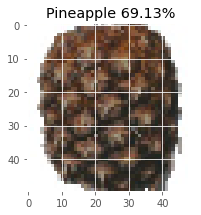

{'Apricot': '0.00%',
 'Avocado': '1.75%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '69.54%',
 'Raspberry': '0.00%',
 'Strawberry': '28.70%',
 'Watermelon': '0.00%'}
Prediction: Pineapple (class 9) 69.54%


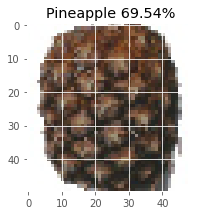

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '95.36%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '4.64%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Cocos (class 4) 95.36%


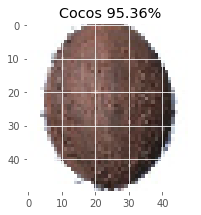

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '95.93%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '4.07%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Cocos (class 4) 95.93%


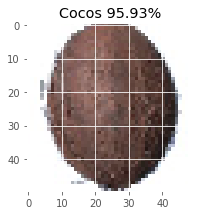

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '67.90%',
 'Cauliflower': '0.53%',
 'Cocos': '0.00%',
 'Corn': '24.04%',
 'Lemon': '5.34%',
 'Mandarine': '0.08%',
 'Pear': '1.95%',
 'Pineapple': '0.15%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.01%'}
Prediction: Banana (class 2) 67.90%


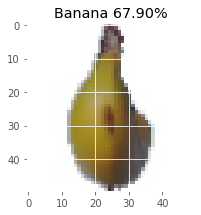

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '72.13%',
 'Cauliflower': '0.46%',
 'Cocos': '0.00%',
 'Corn': '20.53%',
 'Lemon': '5.13%',
 'Mandarine': '0.09%',
 'Pear': '1.47%',
 'Pineapple': '0.18%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.01%'}
Prediction: Banana (class 2) 72.13%


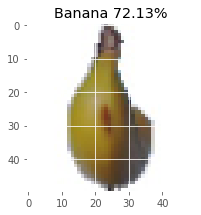

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.04%',
 'Mandarine': '0.00%',
 'Pear': '98.01%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '1.96%'}
Prediction: Pear (class 8) 98.01%


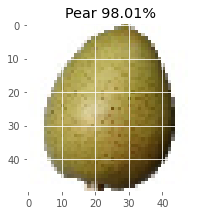

{'Apricot': '0.01%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '99.99%',
 'Watermelon': '0.00%'}
Prediction: Strawberry (class 11) 99.99%


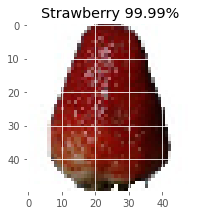

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.05%',
 'Mandarine': '0.00%',
 'Pear': '97.88%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '2.07%'}
Prediction: Pear (class 8) 97.88%


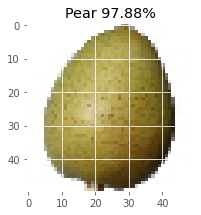

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.01%',
 'Lemon': '99.86%',
 'Mandarine': '0.13%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Lemon (class 6) 99.86%


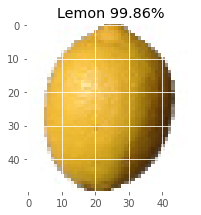

{'Apricot': '0.02%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '99.98%',
 'Watermelon': '0.00%'}
Prediction: Strawberry (class 11) 99.98%


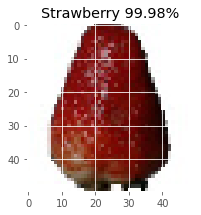

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.01%',
 'Lemon': '99.83%',
 'Mandarine': '0.16%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Lemon (class 6) 99.83%


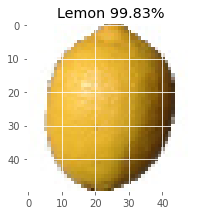

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.01%',
 'Mandarine': '0.00%',
 'Pear': '92.66%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '7.33%'}
Prediction: Pear (class 8) 92.66%


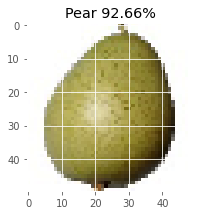

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.01%',
 'Lemon': '99.90%',
 'Mandarine': '0.08%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Lemon (class 6) 99.90%


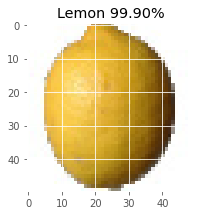

{'Apricot': '0.11%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '99.89%',
 'Watermelon': '0.00%'}
Prediction: Strawberry (class 11) 99.89%


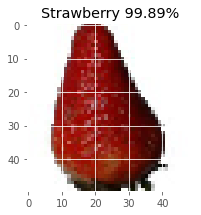

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.01%',
 'Mandarine': '0.00%',
 'Pear': '92.85%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '7.14%'}
Prediction: Pear (class 8) 92.85%


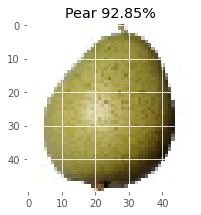

{'Apricot': '0.10%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '99.90%',
 'Watermelon': '0.00%'}
Prediction: Strawberry (class 11) 99.90%


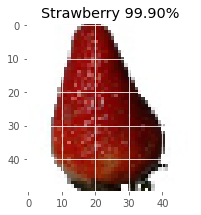

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.01%',
 'Lemon': '99.90%',
 'Mandarine': '0.08%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Lemon (class 6) 99.90%


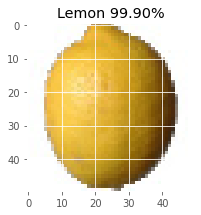

{'Apricot': '0.00%',
 'Avocado': '99.99%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.01%',
 'Watermelon': '0.00%'}
Prediction: Avocado (class 1) 99.99%


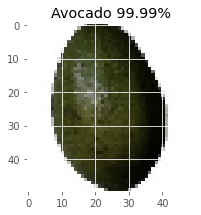

{'Apricot': '0.00%',
 'Avocado': '99.99%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.01%',
 'Watermelon': '0.00%'}
Prediction: Avocado (class 1) 99.99%


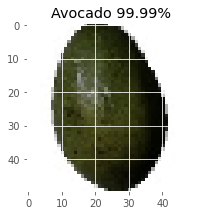

{'Apricot': '96.70%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '3.30%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Apricot (class 0) 96.70%


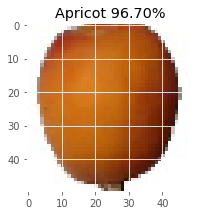

{'Apricot': '97.20%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '2.80%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Apricot (class 0) 97.20%


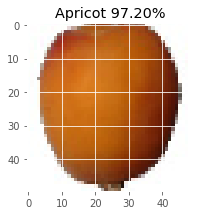

{'Apricot': '0.00%',
 'Avocado': '100.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Avocado (class 1) 100.00%


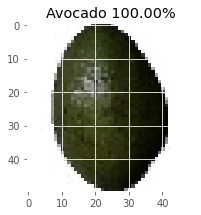

{'Apricot': '0.00%',
 'Avocado': '100.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Avocado (class 1) 100.00%


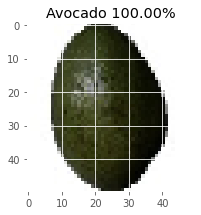

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '86.50%',
 'Cauliflower': '0.07%',
 'Cocos': '0.00%',
 'Corn': '13.06%',
 'Lemon': '0.35%',
 'Mandarine': '0.00%',
 'Pear': '0.01%',
 'Pineapple': '0.01%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Banana (class 2) 86.50%


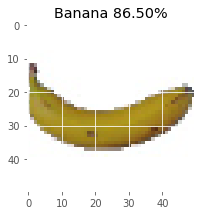

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '86.82%',
 'Cauliflower': '0.07%',
 'Cocos': '0.00%',
 'Corn': '12.72%',
 'Lemon': '0.36%',
 'Mandarine': '0.00%',
 'Pear': '0.01%',
 'Pineapple': '0.01%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Banana (class 2) 86.82%


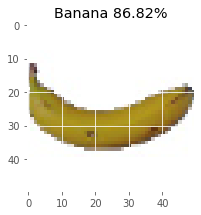

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.84%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '67.93%',
 'Lemon': '31.07%',
 'Mandarine': '0.00%',
 'Pear': '0.15%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Corn (class 5) 67.93%


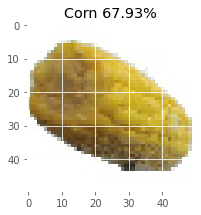

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.93%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '72.81%',
 'Lemon': '26.14%',
 'Mandarine': '0.00%',
 'Pear': '0.12%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Corn (class 5) 72.81%


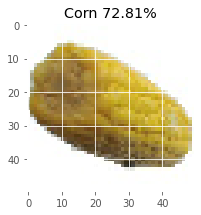

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '98.21%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.43%',
 'Pineapple': '1.20%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.14%'}
Prediction: Cauliflower (class 3) 98.21%


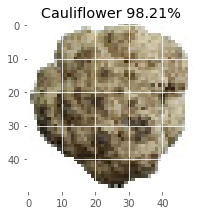

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '98.12%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.51%',
 'Pineapple': '1.21%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.15%'}
Prediction: Cauliflower (class 3) 98.12%


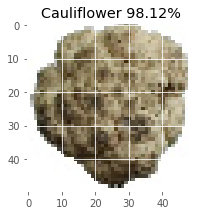

{'Apricot': '0.00%',
 'Avocado': '0.37%',
 'Banana': '0.00%',
 'Cauliflower': '89.89%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '1.36%',
 'Pineapple': '5.33%',
 'Raspberry': '0.00%',
 'Strawberry': '0.11%',
 'Watermelon': '2.93%'}
Prediction: Cauliflower (class 3) 89.89%


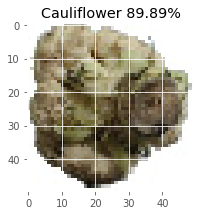

{'Apricot': '0.01%',
 'Avocado': '0.68%',
 'Banana': '0.00%',
 'Cauliflower': '83.25%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '2.37%',
 'Pineapple': '7.03%',
 'Raspberry': '0.00%',
 'Strawberry': '0.25%',
 'Watermelon': '6.41%'}
Prediction: Cauliflower (class 3) 83.25%


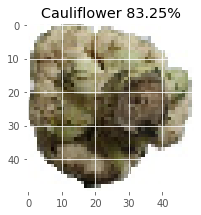

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.01%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.06%',
 'Lemon': '96.00%',
 'Mandarine': '0.39%',
 'Pear': '3.54%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Lemon (class 6) 96.00%


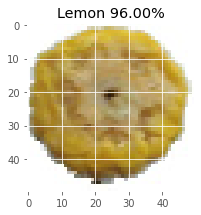

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.01%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.05%',
 'Lemon': '96.28%',
 'Mandarine': '0.46%',
 'Pear': '3.19%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Lemon (class 6) 96.28%


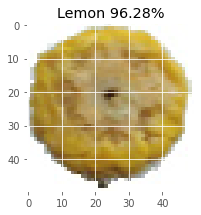

{'Apricot': '0.00%',
 'Avocado': '0.02%',
 'Banana': '0.00%',
 'Cauliflower': '0.20%',
 'Cocos': '87.55%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '12.18%',
 'Raspberry': '0.00%',
 'Strawberry': '0.04%',
 'Watermelon': '0.00%'}
Prediction: Cocos (class 4) 87.55%


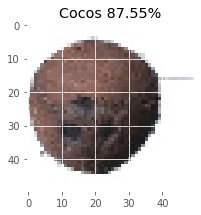

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '100.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Raspberry (class 10) 100.00%


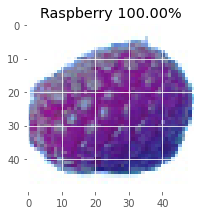

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '100.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Raspberry (class 10) 100.00%


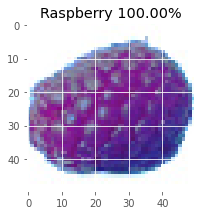

{'Apricot': '0.00%',
 'Avocado': '3.06%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '59.95%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '35.94%',
 'Raspberry': '0.00%',
 'Strawberry': '1.05%',
 'Watermelon': '0.00%'}
Prediction: Cocos (class 4) 59.95%


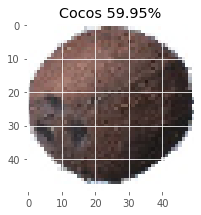

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '6.81%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '61.16%',
 'Lemon': '31.31%',
 'Mandarine': '0.02%',
 'Pear': '0.70%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Corn (class 5) 61.16%


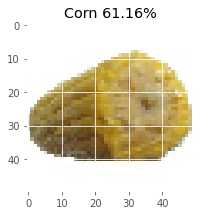

{'Apricot': '0.00%',
 'Avocado': '77.83%',
 'Banana': '0.00%',
 'Cauliflower': '0.09%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '15.05%',
 'Raspberry': '0.00%',
 'Strawberry': '7.03%',
 'Watermelon': '0.00%'}
Prediction: Avocado (class 1) 77.83%


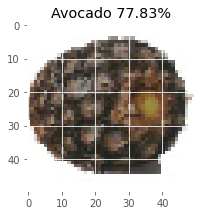

{'Apricot': '0.00%',
 'Avocado': '61.75%',
 'Banana': '0.00%',
 'Cauliflower': '0.06%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '25.51%',
 'Raspberry': '0.00%',
 'Strawberry': '12.66%',
 'Watermelon': '0.00%'}
Prediction: Avocado (class 1) 61.75%


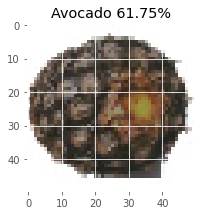

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.08%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '6.50%',
 'Lemon': '93.23%',
 'Mandarine': '0.06%',
 'Pear': '0.14%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Lemon (class 6) 93.23%


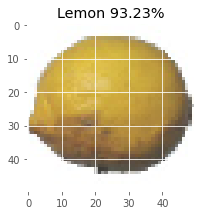

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.07%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '5.95%',
 'Lemon': '93.77%',
 'Mandarine': '0.06%',
 'Pear': '0.14%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Lemon (class 6) 93.77%


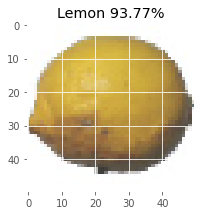

{'Apricot': '0.00%',
 'Avocado': '0.09%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.15%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '1.80%',
 'Watermelon': '97.95%'}
Prediction: Watermelon (class 12) 97.95%


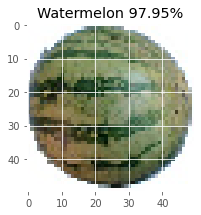

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '95.62%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '4.38%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Cocos (class 4) 95.62%


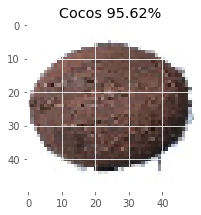

{'Apricot': '0.01%',
 'Avocado': '0.12%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.18%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '2.01%',
 'Watermelon': '97.68%'}
Prediction: Watermelon (class 12) 97.68%


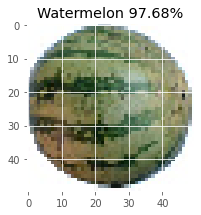

{'Apricot': '0.00%',
 'Avocado': '0.03%',
 'Banana': '0.00%',
 'Cauliflower': '97.52%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.30%',
 'Pineapple': '1.89%',
 'Raspberry': '0.00%',
 'Strawberry': '0.01%',
 'Watermelon': '0.25%'}
Prediction: Cauliflower (class 3) 97.52%


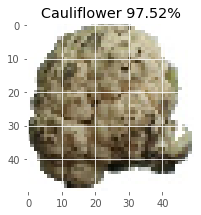

{'Apricot': '0.00%',
 'Avocado': '0.01%',
 'Banana': '0.00%',
 'Cauliflower': '98.55%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.15%',
 'Pineapple': '1.20%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.08%'}
Prediction: Cauliflower (class 3) 98.55%


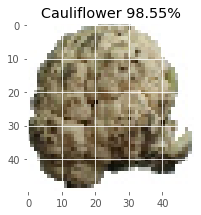

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '97.76%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '2.24%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Cocos (class 4) 97.76%


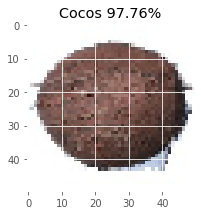

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.02%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '2.93%',
 'Lemon': '96.63%',
 'Mandarine': '0.04%',
 'Pear': '0.37%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Lemon (class 6) 96.63%


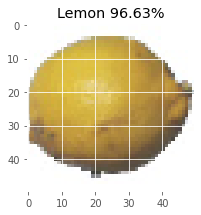

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.01%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '1.05%',
 'Lemon': '98.66%',
 'Mandarine': '0.06%',
 'Pear': '0.23%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Lemon (class 6) 98.66%


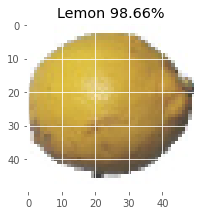

{'Apricot': '0.00%',
 'Avocado': '0.11%',
 'Banana': '0.00%',
 'Cauliflower': '0.01%',
 'Cocos': '0.06%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '96.19%',
 'Raspberry': '0.00%',
 'Strawberry': '3.62%',
 'Watermelon': '0.00%'}
Prediction: Pineapple (class 9) 96.19%


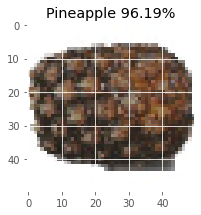

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '100.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Mandarine (class 7) 100.00%


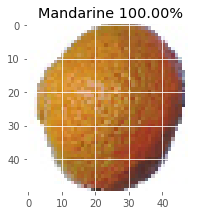

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '100.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Mandarine (class 7) 100.00%


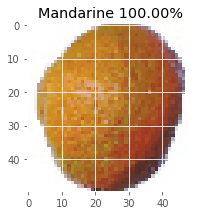

{'Apricot': '0.03%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '1.19%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.22%',
 'Pear': '0.00%',
 'Pineapple': '98.37%',
 'Raspberry': '0.00%',
 'Strawberry': '0.19%',
 'Watermelon': '0.00%'}
Prediction: Pineapple (class 9) 98.37%


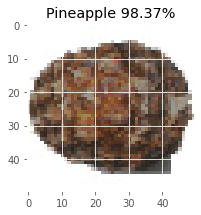

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '100.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Raspberry (class 10) 100.00%


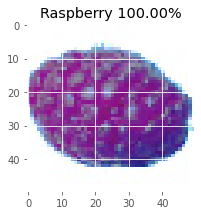

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '86.44%',
 'Cauliflower': '0.44%',
 'Cocos': '0.00%',
 'Corn': '13.02%',
 'Lemon': '0.09%',
 'Mandarine': '0.00%',
 'Pear': '0.01%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Banana (class 2) 86.44%


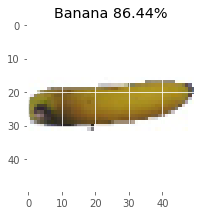

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '84.83%',
 'Cauliflower': '0.31%',
 'Cocos': '0.00%',
 'Corn': '14.75%',
 'Lemon': '0.10%',
 'Mandarine': '0.00%',
 'Pear': '0.01%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Banana (class 2) 84.83%


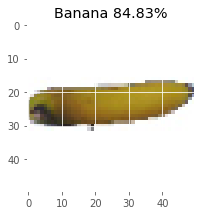

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.02%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.32%',
 'Mandarine': '0.02%',
 'Pear': '98.28%',
 'Pineapple': '0.04%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '1.31%'}
Prediction: Pear (class 8) 98.28%


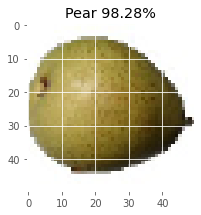

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '100.00%',
 'Watermelon': '0.00%'}
Prediction: Strawberry (class 11) 100.00%


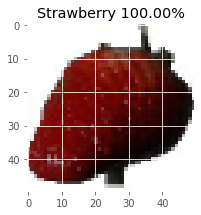

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '100.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Raspberry (class 10) 100.00%


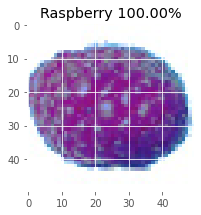

{'Apricot': '99.39%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.61%',
 'Watermelon': '0.00%'}
Prediction: Apricot (class 0) 99.39%


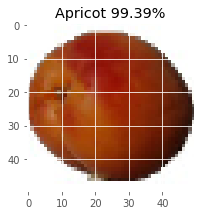

{'Apricot': '99.30%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.70%',
 'Watermelon': '0.00%'}
Prediction: Apricot (class 0) 99.30%


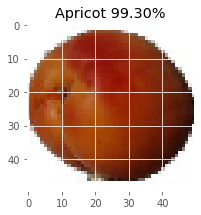

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '68.58%',
 'Cauliflower': '0.26%',
 'Cocos': '0.00%',
 'Corn': '31.09%',
 'Lemon': '0.05%',
 'Mandarine': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Banana (class 2) 68.58%


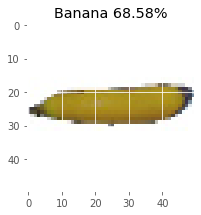

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '89.31%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '10.68%'}
Prediction: Pear (class 8) 89.31%


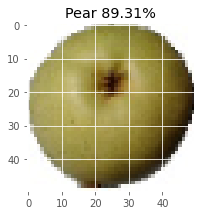

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '72.32%',
 'Cauliflower': '0.33%',
 'Cocos': '0.00%',
 'Corn': '27.31%',
 'Lemon': '0.04%',
 'Mandarine': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Banana (class 2) 72.32%


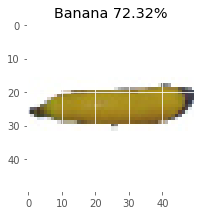

{'Apricot': '0.01%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '99.99%',
 'Watermelon': '0.00%'}
Prediction: Strawberry (class 11) 99.99%


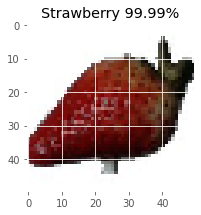

{'Apricot': '0.00%',
 'Avocado': '99.99%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.01%',
 'Watermelon': '0.00%'}
Prediction: Avocado (class 1) 99.99%


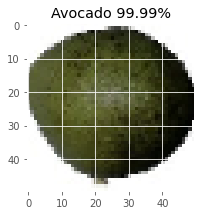

{'Apricot': '0.00%',
 'Avocado': '99.99%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.01%',
 'Watermelon': '0.00%'}
Prediction: Avocado (class 1) 99.99%


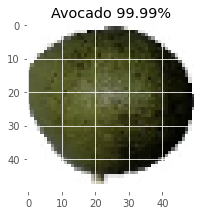

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '87.67%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '12.33%'}
Prediction: Pear (class 8) 87.67%


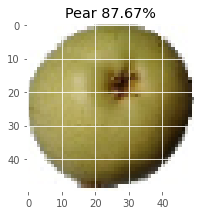

{'Apricot': '0.02%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '99.98%',
 'Watermelon': '0.00%'}
Prediction: Strawberry (class 11) 99.98%


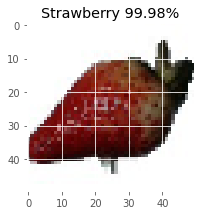

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.45%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '87.10%',
 'Lemon': '12.40%',
 'Mandarine': '0.00%',
 'Pear': '0.05%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Corn (class 5) 87.10%


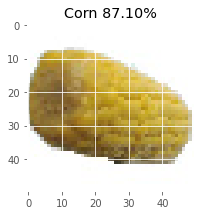

{'Apricot': '99.54%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.46%',
 'Watermelon': '0.00%'}
Prediction: Apricot (class 0) 99.54%


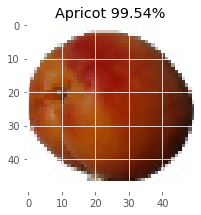

{'Apricot': '0.00%',
 'Avocado': '23.21%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.02%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '12.44%',
 'Watermelon': '64.32%'}
Prediction: Watermelon (class 12) 64.32%


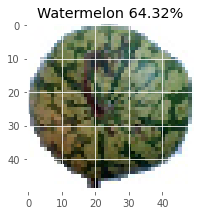

{'Apricot': '0.00%',
 'Avocado': '23.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.02%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '12.40%',
 'Watermelon': '64.58%'}
Prediction: Watermelon (class 12) 64.58%


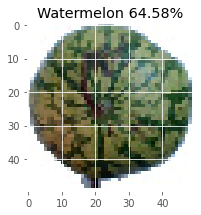

{'Apricot': '99.99%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.01%',
 'Watermelon': '0.00%'}
Prediction: Apricot (class 0) 99.99%


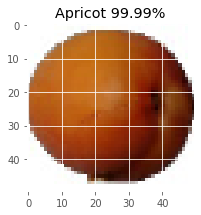

{'Apricot': '99.99%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.01%',
 'Watermelon': '0.00%'}
Prediction: Apricot (class 0) 99.99%


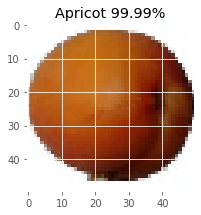

{'Apricot': '99.50%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.50%',
 'Watermelon': '0.00%'}
Prediction: Apricot (class 0) 99.50%


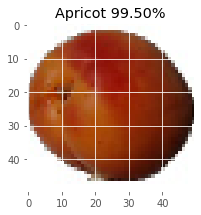

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '99.99%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Mandarine (class 7) 99.99%


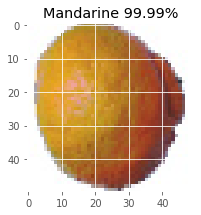

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '99.99%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '0.00%'}
Prediction: Mandarine (class 7) 99.99%


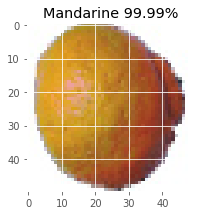

{'Apricot': '0.00%',
 'Avocado': '99.77%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.20%',
 'Watermelon': '0.03%'}
Prediction: Avocado (class 1) 99.77%


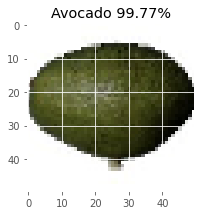

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '70.40%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%',
 'Watermelon': '29.59%'}
Prediction: Pear (class 8) 70.40%


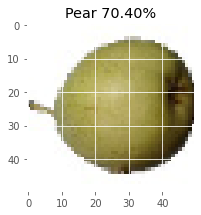

{'Apricot': '0.00%',
 'Avocado': '99.75%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.22%',
 'Watermelon': '0.04%'}
Prediction: Avocado (class 1) 99.75%


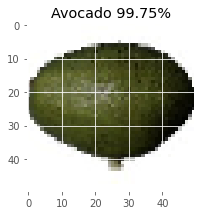

{'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Cauliflower': '0.00%',
 'Cocos': '0.00%',
 'Corn': '0.00%',
 'Lemon': '0.00%',
 'Mandarine': '0.00%',
 'Pear': '0.00%',
 'Pineapple': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '100.00%',
 'Watermelon': '0.00%'}
Prediction: Strawberry (class 11) 100.00%


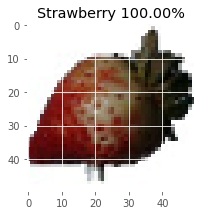

<Figure size 432x288 with 0 Axes>

In [25]:
#predict image with the best model = model1
PREDICTION_PATH = results_path = '/content/drive/My Drive/DeepLearning_2020/FinalProject/New_Dataset/for-prediction'
images_for_prediction = [filename for filename in sorted(os.listdir(PREDICTION_PATH)) if filename.endswith(".jpg")]


for filename in images_for_prediction:
    loaded_image = k.preprocessing.image.load_img(path=PREDICTION_PATH+'/'+filename, target_size=(img_width, img_height, img_num_channels))
    #convert to array and resample dividing by 255
    img_array = k.preprocessing.image.img_to_array(loaded_image) / 255.

    img_np_array = np.expand_dims(img_array, axis = 0)

    predictions = model1.predict(img_np_array)
    classidx = np.argmax(predictions[0])
    label = trained_classes_labels[classidx]

    predictions_pct = ["{:.2f}%".format(prob * 100) for prob in predictions[0] ]
    pprint(dict(zip(trained_classes_labels, predictions_pct)) )
    print("Prediction: %s (class %s) %s" % (label, classidx, predictions_pct[classidx])) 

    plt.figure(figsize=(3,4))
    plt.imshow(img_array)
    plt.title("%s %s" % (label, predictions_pct[classidx]))
    plt.show()

plt.gcf().clear()


Transfer learning with MobileNet

In [0]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam

In [28]:
base_model=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
#Add last layers on top of mobilenet pre-trained
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(no_classes,activation='softmax')(x) #final layer with softmax activation

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [29]:
model=Model(inputs=base_model.input,outputs=preds)
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128 

In [0]:
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [31]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) 

train_generator=train_datagen.flow_from_directory(data_path + '/Training_small', 
                                                 target_size=(50,50),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 2176 images belonging to 13 classes.


In [32]:
test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) 

test_generator=test_datagen.flow_from_directory(data_path + '/Test_small', 
                                                 target_size=(50,50),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 676 images belonging to 13 classes.


In [33]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])


history = model.fit_generator(generator=train_generator, validation_data=test_generator,
                   epochs=no_epochs)

Epoch 1/20
68/68 [==============================] - 45s 660ms/step - loss: 0.5641 - accuracy: 0.8690 - val_loss: 2.2852 - val_accuracy: 0.5888
Epoch 2/20
68/68 [==============================] - 40s 594ms/step - loss: 0.2181 - accuracy: 0.9563 - val_loss: 2.7132 - val_accuracy: 0.5518
Epoch 3/20
68/68 [==============================] - 41s 598ms/step - loss: 0.1841 - accuracy: 0.9609 - val_loss: 0.0029 - val_accuracy: 0.6908
Epoch 4/20
68/68 [==============================] - 40s 594ms/step - loss: 0.2850 - accuracy: 0.9531 - val_loss: 1.6097 - val_accuracy: 0.6391
Epoch 5/20
68/68 [==============================] - 40s 593ms/step - loss: 0.2116 - accuracy: 0.9591 - val_loss: 0.7455 - val_accuracy: 0.8639
Epoch 6/20
68/68 [==============================] - 40s 595ms/step - loss: 0.3177 - accuracy: 0.9485 - val_loss: 2.0075 - val_accuracy: 0.8979
Epoch 7/20
68/68 [==============================] - 41s 600ms/step - loss: 0.1355 - accuracy: 0.9789 - val_loss: 2.1696 - val_accuracy: 0.8728

22/22 [==============================] - 3s 135ms/step
Test loss: 0.5760190486907959
Test accuracy: 0.9748520851135254
dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


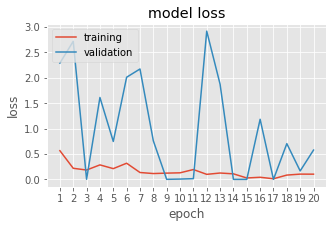

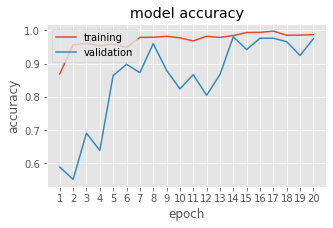

In [34]:
score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print(history.history.keys())

plt.style.use('ggplot')

xepochs = [i+1 for i in range(0, len(history.history['loss']))]
plt.figure(figsize=(5,3))
# Loss
#plt.ylim([-0.1,0.5])
plt.plot(xepochs, history.history['loss'])
plt.plot(xepochs, history.history['val_loss'])
plt.xticks(xepochs)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

# Accuracy
#plt.ylim([0.7,1.05])
plt.figure(figsize=(5,3))
plt.plot(xepochs, history.history['accuracy'])
plt.plot(xepochs, history.history['val_accuracy'])
plt.xticks(xepochs)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()